# **Hyperparameter Tuning for Neural Networks with Keras Tuner**

!["Fashion"](Fashion.png)

This notebook demonstrates the process of designing, training, and optimizing neural networks for image classification using the Fashion MNIST dataset. The main objective is to explore and apply various techniques to improve model performance by tuning hyperparameters efficiently.

## **What You'll Learn**
1. **Data Preprocessing**:
   - Reshaping and normalizing the Fashion MNIST dataset to prepare it for training.

2. **Model Architecture Design**:
   - Constructing fully connected neural networks with varying layers, units, and dropout rates.
   - Testing different optimizers, including SGD and Adam, to evaluate their impact on training.

3. **Hyperparameter Tuning with Keras Tuner**:
   - Leveraging Keras Tuner's Hyperband method to explore hyperparameters such as:
     - Number of units per layer.
     - Number of layers.
     - Dropout rates.
     - Batch sizes.
   - Using EarlyStopping to terminate training early for underperforming configurations.
   - Data Augmentation.

4. **Performance Optimization**:
   - Applying strategies to accelerate hyperparameter tuning, such as limiting trials and refining search ranges.

## **Why This Notebook?**
Hyperparameter tuning is a critical step in building robust machine learning models. By following the steps outlined here, you'll gain practical experience in optimizing neural networks, balancing model complexity with computational efficiency, and effectively using tools like Keras Tuner to streamline the tuning process.

Let’s dive in and build a high-performing model for the Fashion MNIST dataset! 🚀

* GitHub: https://github.com/AleGallagher

## **Collecting and preprocessing data**

In [5]:
from tensorflow.keras import datasets
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Hold out set**

Training, validation and test sets generation.

In [7]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [11]:
y_train.size

60000

In [13]:
pd.Series(y_train).value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

In [15]:
y_test.size

5000

In [17]:
pd.Series(y_test).value_counts()

7    526
5    526
9    508
3    506
8    502
6    499
0    493
1    483
4    480
2    477
Name: count, dtype: int64

In [19]:
y_val.size

5000

In [21]:
pd.Series(y_val).value_counts()

2    523
4    520
1    517
0    507
6    501
8    498
3    494
9    492
5    474
7    474
Name: count, dtype: int64

We have 60000 examples in the training set, and 5000 examples in the test and validation sets. Also, we have the same number of examples of each type of clothes in the test and validation test.

Let's visualise some examples

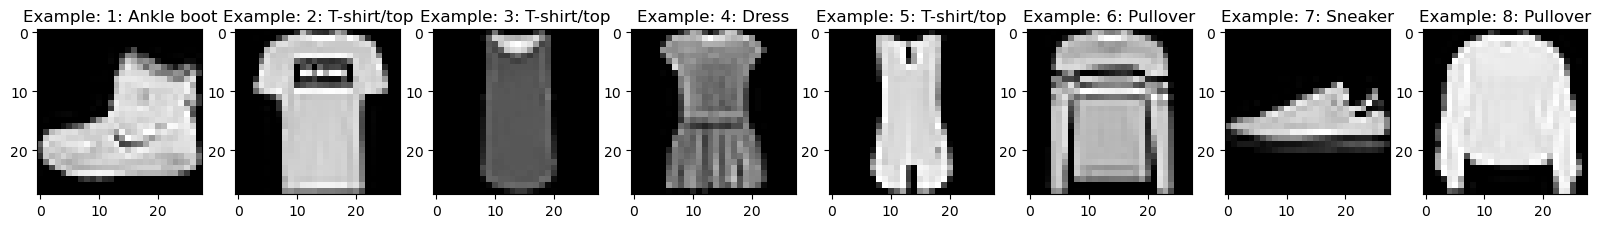

In [23]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

plt.figure(figsize=(20,4))
for index, img, img_class in zip(range(1,9), X_train[:8], y_train[:8]):
    plt.subplot(1, 8, index)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Example: " + str(index) + ": " + class_labels[img_class])

### **Data Preprocessing**

In [25]:
transformer = Normalizer()
X_train_prep = transformer.fit_transform(X_train.reshape((X_train.shape[0], 28*28)))
X_val_prep = transformer.transform(X_val.reshape((X_val.shape[0], 28*28)))
X_test_prep = transformer.transform(X_test.reshape((X_val.shape[0], 28*28)))
print(X_train_prep.shape)

(60000, 784)


In [27]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)
networks = {}

## **Models**

### Base Model

To start with this, I define a simple architecture with just one fully connected hidden layer, and one output layer with 10 units, one for each type of the clothes. It uses SGD Batch as optimizer.


In [29]:
sgd_network = models.Sequential()
sgd_network.add(layers.Input(shape=(28*28,)))
sgd_network.add(layers.Dense(300, activation='relu'))
sgd_network.add(layers.Dense(10, activation='softmax'))

sgd_network.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy', 'Precision']
                    )

sgd_network_history = sgd_network.fit(X_train_prep, y_train_categorical, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))
networks["sgd"] = sgd_network_history

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.0000e+00 - accuracy: 0.4104 - loss: 2.1893 - val_Precision: 0.0000e+00 - val_accuracy: 0.5744 - val_loss: 1.7299
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.6947 - accuracy: 0.5911 - loss: 1.5711 - val_Precision: 0.9630 - val_accuracy: 0.6392 - val_loss: 1.2446
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9456 - accuracy: 0.6654 - loss: 1.1635 - val_Precision: 0.9061 - val_accuracy: 0.6752 - val_loss: 1.0150
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - Precision: 0.9249 - accuracy: 0.7046 - loss: 0.9593 - val_Precision: 0.9073 - val_accuracy: 0.7052 - val_loss: 0.8828
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9151 - accuracy: 0.7350 - loss: 0.8299 - val_Precision: 0.8941 - val_accuracy: 0.7244 - val_loss: 0.7986
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9027 - accuracy: 0.7491 - loss: 0.7536 - val_Precis

In [31]:
def plot_model_accuracy(network_history, model_name):
  """
  Plot the accuracy and val accuracy curves of the history network
  """
  history_df = pd.DataFrame(network_history.history)
  history_df = history_df[['accuracy', 'val_accuracy']].reset_index().melt(
      id_vars='index',
      value_vars=['accuracy', 'val_accuracy'],
      var_name='Metric',
      value_name='Accuracy'
  )

  history_df.rename(columns={'index': 'Epoch'}, inplace=True)
  fig, ax = plt.subplots(figsize=(15, 5))
  accuracy_plot = sns.lineplot(data=history_df, x='Epoch', y='Accuracy', hue='Metric', marker='o', palette="colorblind", legend=False)
  accuracy_plot.set_title(f'{model_name}: Accuracy', fontsize=15, loc='left')
  accuracy_plot.set_ylabel('Accuracy', fontsize=13, loc="bottom")
  accuracy_plot.set_xlabel('Epochs', fontsize=13, loc="left")
  sns.despine()

  offset = 0
  for idx, metric in enumerate(history_df['Metric'].unique()):
      subset = history_df[history_df['Metric'] == metric]
      last_epoch = subset['Epoch'].iloc[-1]
      last_accuracy = subset['Accuracy'].iloc[-1]
      adjusted_accuracy = last_accuracy - offset
      ax.text(
          last_epoch + 0.9,
          adjusted_accuracy,
          metric,
          fontsize=12,
          color=ax.lines[idx].get_color(),
          va='center'
      )
      last_epoch = subset['Epoch'].iloc[-1]
      last_accuracy = subset['Accuracy'].iloc[-1]
      ax.text(
        last_epoch + 0.3,
        adjusted_accuracy,
        f"{last_accuracy:.2f}",
        fontsize=12,
        color=ax.lines[idx].get_color(),
        va='center',
        ha='left'
      )
      offset = 0.006
  plt.show()

def plot_model_loss(network_history, model_name):
  """
  Plot the loss and val loss curves of the history network
  """
  history_df = pd.DataFrame(network_history.history)
  history_df = history_df[['loss', 'val_loss']].reset_index().melt(
      id_vars='index',
      value_vars=['loss', 'val_loss'],
      var_name='Metric',
      value_name='Loss'
  )

  history_df.rename(columns={'index': 'Epoch'}, inplace=True)
  fig, ax = plt.subplots(figsize=(15, 5))
  loss_plot = sns.lineplot(data=history_df, x='Epoch', y='Loss', hue='Metric', marker='o', palette="colorblind", legend=False)
  loss_plot.set_title(f'{model_name}: Loss', fontsize=15, loc='left')
  loss_plot.set_ylabel('Loss', fontsize=13, loc="bottom")
  loss_plot.set_xlabel('Epochs', fontsize=13, loc="left")
  sns.despine()
  offset = 0.09
  for idx, metric in enumerate(history_df['Metric'].unique()):
      subset = history_df[history_df['Metric'] == metric]
      last_epoch = subset['Epoch'].iloc[-1]
      last_loss = subset['Loss'].iloc[-1]

      adjusted_loss = last_loss - offset * last_loss
      ax.text(
          last_epoch + 0.9,
          last_loss,
          metric,
          fontsize=12,
          color=ax.lines[idx].get_color(),
          va='center'
      )

      ax.text(
        last_epoch + 0.3,
        last_loss,
        f"{last_loss:.2f}",
        fontsize=12,
        color=ax.lines[idx].get_color(),
        va='center',
        ha='left'
      )
      offset = -0.01
  plt.show()

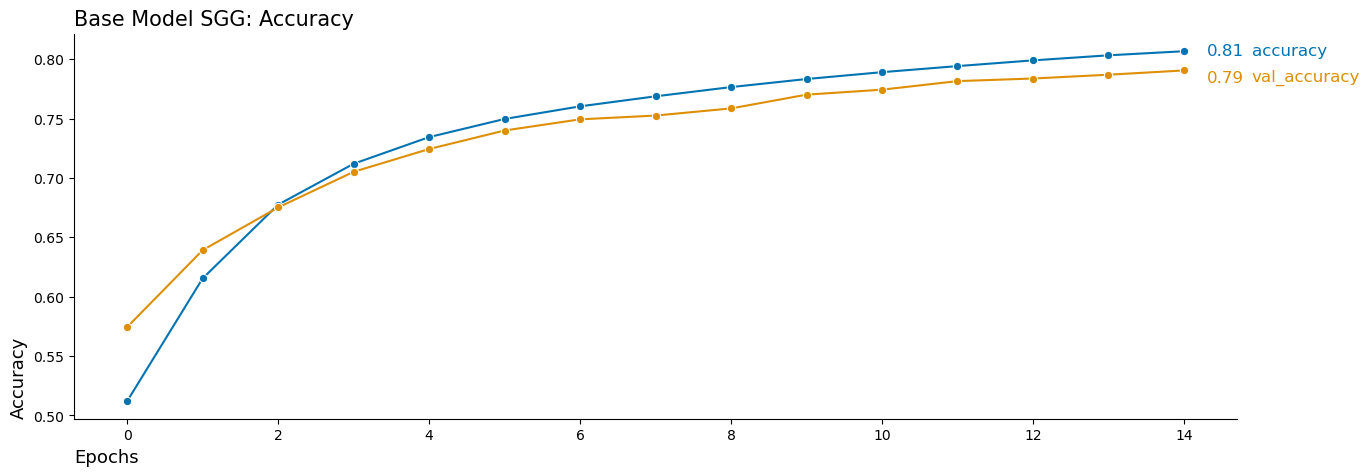

In [33]:
plot_model_accuracy(sgd_network_history, 'Base Model SGG')

Above we can see a bit of overfitting after the epoch 4, and the max **accuracy is 0.8046**, and the **val accuracy is 0.7968**.

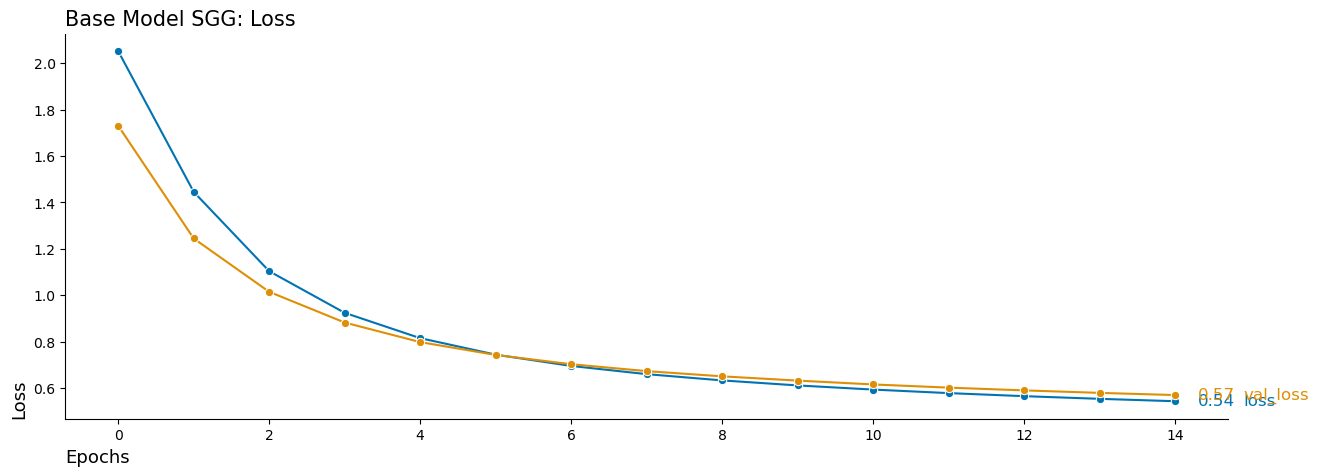

In [35]:
plot_model_loss(sgd_network_history, 'Base Model SGG')

About the loss, we can see how both have similar loss after the epoch 4, ending with a loss of 0.5459 and 0.5647 for the val loss, very similar. And we can see how both continue to decrease.

If we run more epochs, we will see how it continues to decrease:

In [37]:
sgd_network_history_2 = sgd_network.fit(X_train_prep, y_train_categorical, epochs=10,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8771 - accuracy: 0.8099 - loss: 0.5369 - val_Precision: 0.8641 - val_accuracy: 0.7952 - val_loss: 0.5617
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8787 - accuracy: 0.8141 - loss: 0.5270 - val_Precision: 0.8608 - val_accuracy: 0.7978 - val_loss: 0.5547
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8760 - accuracy: 0.8134 - loss: 0.5205 - val_Precision: 0.8619 - val_accuracy: 0.7984 - val_loss: 0.5495
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8754 - accuracy: 0.8154 - loss: 0.5188 - val_Precision: 0.8644 - val_accuracy: 0.8012 - val_loss: 0.5420
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8762 - accuracy: 0.8177 - loss: 0.5092 - val_Precision: 0.8647 - val_accuracy: 0.8040 - val_loss: 0.5369
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8803 - accuracy: 0.8233 - loss: 0.4973 - val_Precision: 0.868

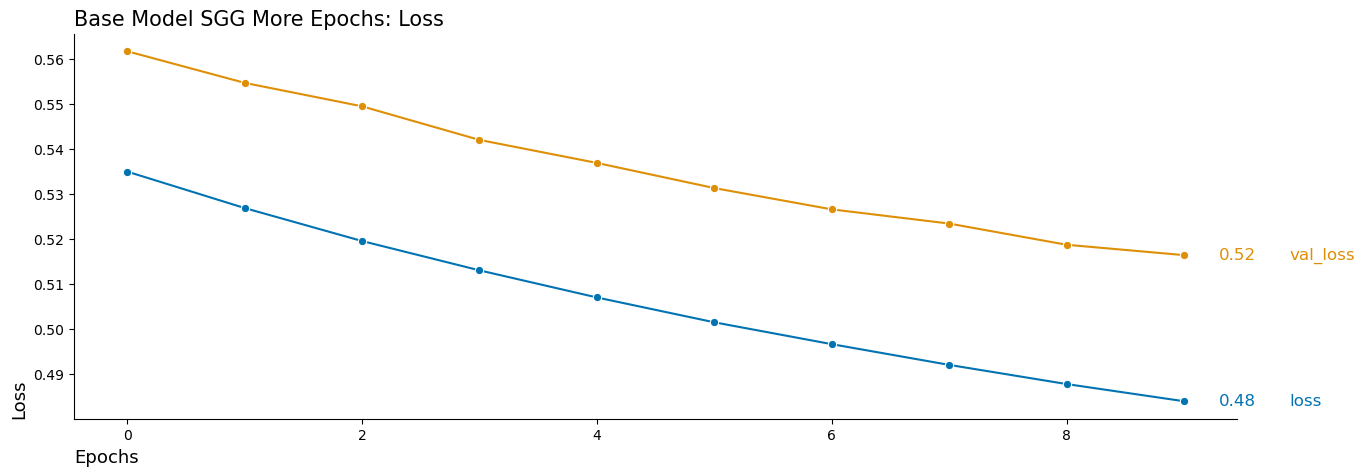

In [39]:
plot_model_loss(sgd_network_history_2, 'Base Model SGG More Epochs')

After running more epochs we could see how the loss has been reduced to 0.4817 and 0.5080 for the val loss.

Now, I will test other models and use hyperparameter tuning in order to try to improve the metrics of the base model.

## **Hyperparameter Tuning**

Let's start playing with hyperparameter tuning, in order to do that I will use Keras Tuner with Hyperband.

I will look for the best values of:
* Units.
* Layers.
* Dropout, in order to reduce the overfitting.

Apart of that, as this method could take a lot of time and consume many resources, I will use a early stopping, to terminate training early for underperforming configuration.

Also, I will try diffirent optimizers.

### **Setup Tuning**

In [41]:
!pip install keras-tuner

In [43]:
import keras_tuner
import IPython
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

In [45]:
def build_model_hp(hp, optimizer_model):
    """
    Builds a customizable neural network model for hyperparameter tuning.

    This function creates a fully connected neural network where the architecture
    (number of layers, units per layer, and dropout rates) is determined by
    hyperparameters sampled during the tuning process. It also compiles the model
    with the specified optimizer.

    Args:
        hp: HyperParameters object from Keras Tuner, used to sample hyperparameter values.
        optimizer_model: An optimizer instance (e.g., SGD, Adam) used to compile the model.

    Returns:
        A compiled Keras Sequential model.

    Architecture:
        - Input Layer: Accepts a flattened 28x28 image (784 features).
        - Hidden Layers:
          - Number of layers is sampled between 1 and 2.
          - First layer units range from 256 to 448 in steps of 64.
          - Subsequent layer units range from 128 to 320 in steps of 32.
          - Dropout rates range from 0.1 to 0.4 in steps of 0.1.
        - Output Layer: A dense layer with 10 units and softmax activation for multi-class classification.
    """
    model = models.Sequential()
    hp_layers = hp.Int('layers', min_value=1, max_value=2, step=1)

    model.add(layers.Input(shape=(28*28,)))
    for i in range(hp_layers):
        if i == 0:
          hp_units = hp.Int(f'units_layer_{i}', min_value=256, max_value=448, step=64)
        else:
          hp_units = hp.Int(f'units_layer_{i}', min_value=128, max_value=320, step=32)
        hp_dropout = hp.Float(f'dropout_rate_layer_{i}', min_value=0.1, max_value=0.4, step=0.1)
        model.add(layers.Dense(units=hp_units, activation='relu'))
        model.add(layers.Dropout(rate=hp_dropout))

    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer_model,
                    metrics=['accuracy'])

    return model

In [47]:
def build_hp(optimizer_name):
  """
  Builds a Keras Tuner Hyperband instance for hyperparameter optimization.

  This function sets up a Hyperband tuner to search for the best hyperparameters
  for a given optimizer. It leverages the `build_model_hp` function to create a
  neural network model with tunable architecture and uses the specified optimizer
  name to customize the optimizer's configuration during the search.

  Args:
      optimizer_name: A string representing the name of the optimizer to use (e.g., "adam", "sgd").

  Returns:
      A configured Keras Tuner Hyperband instance ready for hyperparameter search.

  Hyperband Configuration:
      - Objective: Maximize validation accuracy (`val_accuracy`).
      - Maximum Epochs: 15 epochs per trial.
      - Factor: Reduction factor of 3 for bracket evaluation.
      - Project Name: Used to save the results under the optimizer's name.

  Notes:
      The optimizer configuration is determined by the `get_optimizer` function,
      which must handle any hyperparameters specific to the optimizer being used.
  """
  return keras_tuner.Hyperband(
        lambda hp: build_model_hp(hp, optimizer_model=get_optimizer(hp, optimizer_name)),
        objective='val_accuracy',
        max_epochs=15,
        factor=3,
        project_name=optimizer_name
        )

def get_optimizer(hp, optimizer_name):
  """
  Creates and configures an optimizer based on the specified name and hyperparameters.

  This function generates an optimizer instance using the Keras `optimizers` module.
  It selects the optimizer type based on the provided `optimizer_name` and tunes its
  hyperparameters (e.g., learning rate, momentum) using the `HyperParameters` object.

  Args:
      hp: A `keras_tuner.HyperParameters` object for defining and sampling hyperparameters.
      optimizer_name: A string representing the name of the optimizer to configure.
                        Supported options: 'SGD', 'SGD_MOMENTUM', 'ADAM', 'RMSPROP'.

  Returns:
      An instance of a Keras optimizer configured with the chosen hyperparameters.

  Supported Optimizers:
      - SGD: Stochastic Gradient Descent with tunable learning rate.
      - SGD_MOMENTUM: Stochastic Gradient Descent with Momentum.
        Configurable learning rate and momentum rate.
      - ADAM: Adam optimizer with tunable learning rate.
      - RMSPROP: RMSProp optimizer with tunable learning rate.

  Default Behavior:
      If the `optimizer_name` is unrecognized, returns an SGD optimizer with a default
      learning rate of 0.01.

  Notes:
      This function is typically used within a hyperparameter search framework
      (e.g., Keras Tuner) to optimize models with different optimizer configurations.
  """
  if optimizer_name == 'SGD':
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.1])
    return optimizers.SGD(learning_rate=learning_rate)
  if optimizer_name == 'SGD_MOMENTUM':
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.1])
    momentum_rate = hp.Choice('momentum_rate', values=[0.2, 0.5, 0.7, 0.9, 0.99])
    return optimizers.SGD(learning_rate=learning_rate, momentum=momentum_rate)
  if optimizer_name == 'ADAM':
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.1])
    return optimizers.Adam(learning_rate=learning_rate)
  if optimizer_name == 'RMSPROP':
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.1, 0.001])
    return optimizers.RMSprop(learning_rate=learning_rate)
  else: return optimizers.SGD(learning_rate=0.01)

## **SGD Batch**

The SGD batch optimizer processes a subset of the data (mini-batch) in each iteration, updating the model weights using the average gradient of the loss over the batch. This balances computational efficiency and convergence stability, offering a middle ground between stochastic (single sample) and full-batch gradient descent.

In [49]:
sgd_network_hp = build_hp(optimizer_name='SGD')

In [51]:
sgd_network_hp.search(
    X_train_prep, y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_prep, y_val_categorical),
    callbacks=[early_stopping, ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.8238000273704529

Best val_accuracy So Far: 0.8733999729156494
Total elapsed time: 00h 05m 44s


In [53]:
best_sgd = sgd_network_hp.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp_name in best_sgd.values.keys():
    print(f"{hp_name}: {best_sgd.get(hp_name)}")

Best Hyperparameters:
learning_rate: 0.1
layers: 2
units_layer_0: 320
dropout_rate_layer_0: 0.30000000000000004
units_layer_1: 256
dropout_rate_layer_1: 0.30000000000000004
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [111]:
best_sgd_model = sgd_network_hp.hypermodel.build(best_sgd)
best_sgd_model_history = best_sgd_model.fit(X_train_prep, y_train_categorical, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5535 - loss: 1.2891 - val_accuracy: 0.7876 - val_loss: 0.5655
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7933 - loss: 0.5552 - val_accuracy: 0.8182 - val_loss: 0.4929
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8238 - loss: 0.4838 - val_accuracy: 0.8292 - val_loss: 0.4615
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8368 - loss: 0.4504 - val_accuracy: 0.8450 - val_loss: 0.4252
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8461 - loss: 0.4280 - val_accuracy: 0.8458 - val_loss: 0.4244
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8525 - loss: 0.4090 - val_accuracy: 0.8510 - val_loss: 0.4095
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8540 - loss: 0.3962 - val_accuracy: 0.8580 - val_loss: 0.3933
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8603 - loss: 0.3857 - 

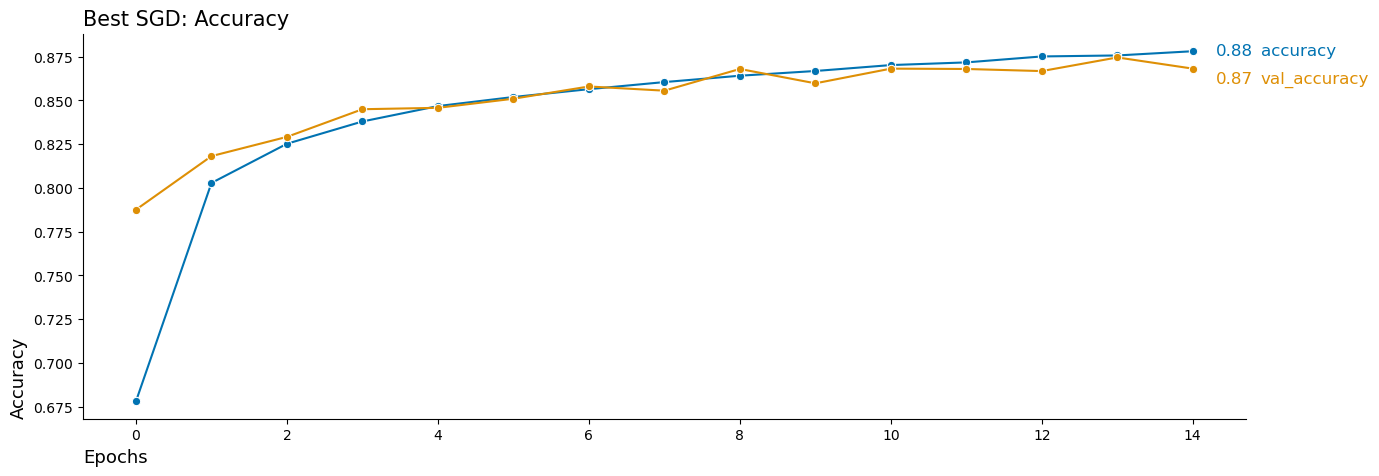

In [113]:
plot_model_accuracy(best_sgd_model_history, 'Best SGD')

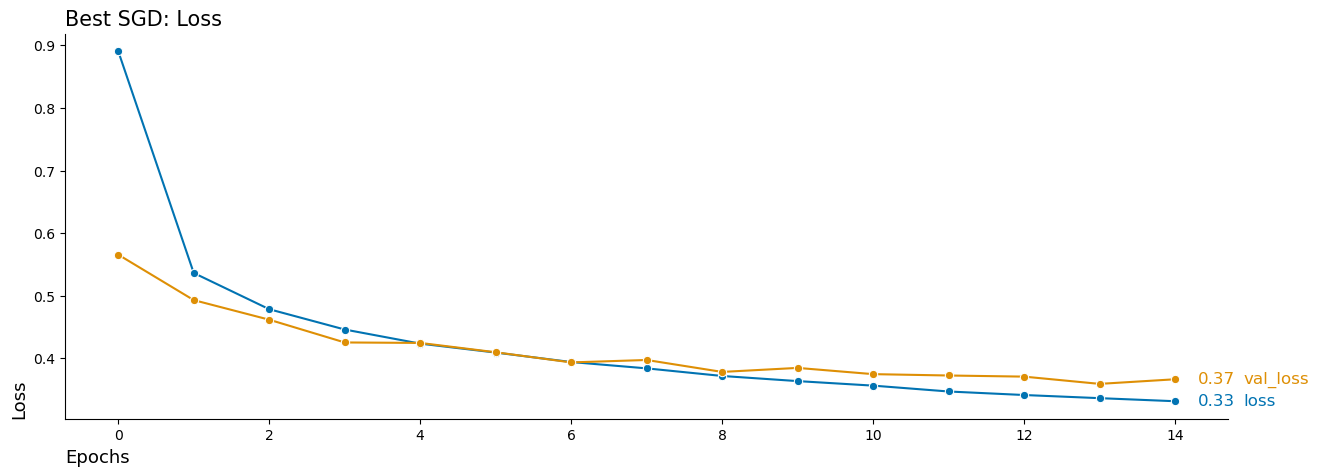

In [115]:
plot_model_loss(best_sgd_model_history, 'Best SGD')

After finding the hyper parameters, we get a better model than the base one, improving the value of val accuracy from 0.79 to 0.87 and reducing the loss from 0.56 to 0.37 with 15 epochs.

Below we can see the difference between the two models:

In [67]:
def compare_accuracy_curve(base_network_history, best_model_history, model_name):
  val_acc_sgd = base_network_history.history['val_accuracy']
  val_acc_best_sgd = best_model_history.history['val_accuracy']

  epochs_sgd = list(range(1, len(val_acc_sgd) + 1))
  epochs_best_sgd = list(range(1, len(val_acc_best_sgd) + 1))
  data = pd.DataFrame({
      'Epoch': epochs_sgd + epochs_best_sgd,
      'Validation Accuracy': val_acc_sgd + val_acc_best_sgd,
      'Model': [model_name] * len(val_acc_sgd) + [f'{model_name} HP'] * len(val_acc_best_sgd)
  })

  plt.figure(figsize=(10, 6))
  compare_plot = sns.lineplot(
      data=data,
      x='Epoch',
      y='Validation Accuracy',
      hue='Model',
      style='Model',
      markers=True,
      dashes=False,
      palette="colorblind"
  )

  compare_plot.set_title(f'{model_name}: Accuracy Comparation', fontsize=15, loc='left')
  compare_plot.set_ylabel('Validation Accuracy', fontsize=13, loc="bottom")
  compare_plot.set_xlabel('Epochs', fontsize=13, loc="left")
  sns.despine()

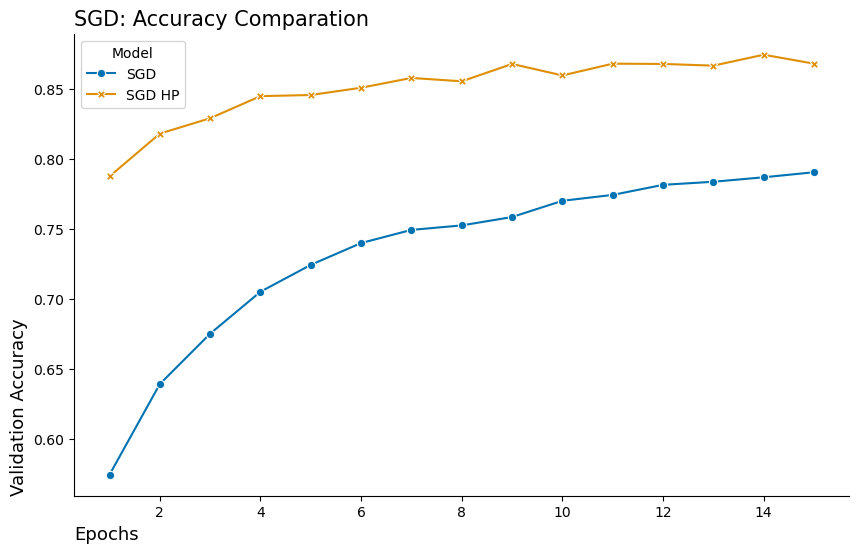

In [117]:
compare_accuracy_curve(sgd_network_history, best_sgd_model_history, 'SGD')

Let's try with other model.

## **SGD Mometum**

SGD with Momentum accelerates convergence by incorporating a fraction of the previous update into the current weight update. This helps the optimizer navigate noisy gradients and overcome local minima by adding inertia to the updates, improving training speed and stability.

### **Base SGD Momentum Model**

In [71]:
network = models.Sequential()
network.add(layers.Input(shape=(28*28,)))
network.add(layers.Dense(300, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

network.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.2),
                metrics=['accuracy', 'Precision'])

sgd_momentum_netwrok_history = network.fit(X_train_prep, y_train_categorical, batch_size=32, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))
networks["sgd_momentum"] = sgd_momentum_netwrok_history

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.3319 - accuracy: 0.3440 - loss: 2.0676 - val_Precision: 0.8964 - val_accuracy: 0.6152 - val_loss: 1.1543
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9292 - accuracy: 0.6692 - loss: 1.0074 - val_Precision: 0.8743 - val_accuracy: 0.7122 - val_loss: 0.7892
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8789 - accuracy: 0.7389 - loss: 0.7258 - val_Precision: 0.8600 - val_accuracy: 0.7476 - val_loss: 0.6721
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8669 - accuracy: 0.7660 - loss: 0.6285 - val_Precision: 0.8510 - val_accuracy: 0.7686 - val_loss: 0.6164
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.8614 - accuracy: 0.7850 - loss: 0.5774 - val_Precision: 0.8461 - val_accuracy: 0.7820 - val_loss: 0.5864
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8633 - accuracy: 0.7989 - loss: 0.5512 - val_Precision: 0.855

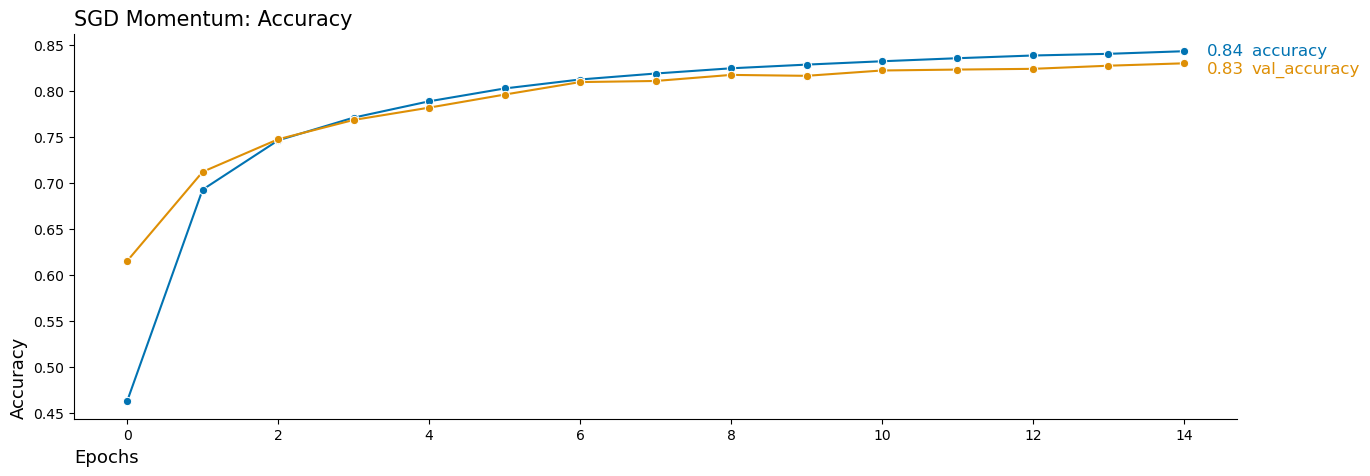

In [73]:
plot_model_accuracy(sgd_momentum_netwrok_history, 'SGD Momentum')

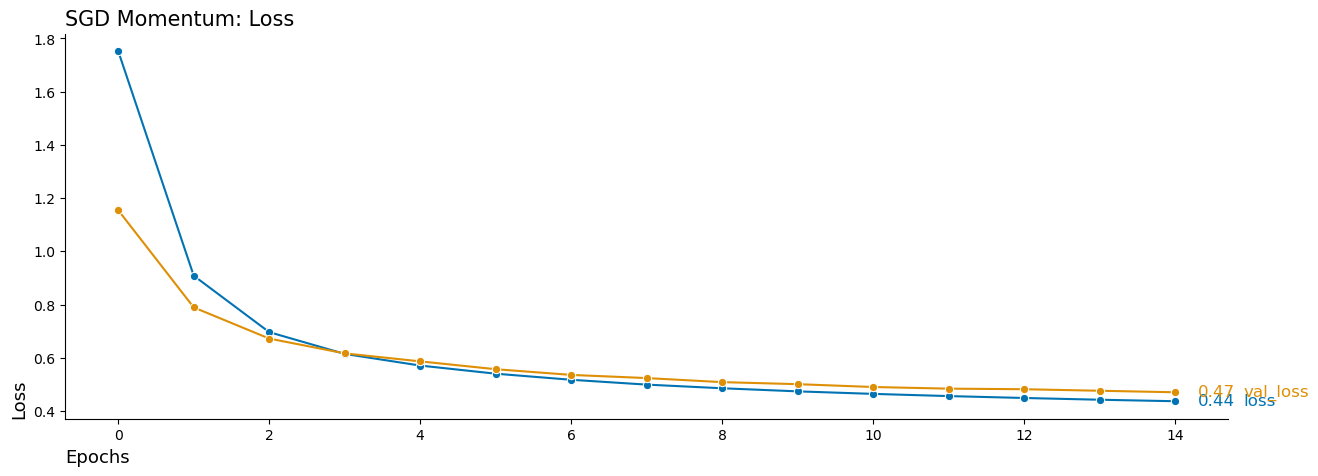

In [75]:
plot_model_loss(sgd_momentum_netwrok_history, 'SGD Momentum')

We get similar results than the SGD model using hyper parameter tunning, with 0.8339 as val accuracy and 0.4623 as val loss. Let's see if we can improve this.

In [77]:
sgd_momentum_network_hp = build_hp(optimizer_name='SGD_MOMENTUM')
sgd_momentum_network_hp.search(
    X_train_prep, y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_prep, y_val_categorical),
    callbacks=[early_stopping, ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 20s]
val_accuracy: 0.8416000008583069

Best val_accuracy So Far: 0.878600001335144
Total elapsed time: 00h 05m 48s


In [79]:
best_sgd_momentum = sgd_momentum_network_hp.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp_name in best_sgd_momentum.values.keys():
    print(f"{hp_name}: {best_sgd_momentum.get(hp_name)}")

Best Hyperparameters:
learning_rate: 0.1
momentum_rate: 0.2
layers: 2
units_layer_0: 320
dropout_rate_layer_0: 0.1
units_layer_1: 288
dropout_rate_layer_1: 0.1
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018


In [119]:
best_sgd_momentum_model = sgd_momentum_network_hp.hypermodel.build(best_sgd_momentum)
best_sgd_momentum_model_history = best_sgd_momentum_model.fit(X_train_prep, y_train_categorical, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6029 - loss: 1.1489 - val_accuracy: 0.7856 - val_loss: 0.5767
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8155 - loss: 0.5044 - val_accuracy: 0.8270 - val_loss: 0.4771
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8348 - loss: 0.4482 - val_accuracy: 0.8350 - val_loss: 0.4442
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8468 - loss: 0.4147 - val_accuracy: 0.8498 - val_loss: 0.4194
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8557 - loss: 0.3955 - val_accuracy: 0.8528 - val_loss: 0.4085
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8631 - loss: 0.3737 - val_accuracy: 0.8430 - val_loss: 0.4252
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8675 - loss: 0.3602 - val_accuracy: 0.8612 - val_loss: 0.3964
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8726 - loss: 0.3478 - 

With the hyperparameter tuning, I could improve the metrics, the val accuracy from 0.8330 to 0.8648 and the val loss from 0.4623 to 0.3871. All of this with just one layer instead of two. So far this is the best model, althougt it has a bit of overfitting.

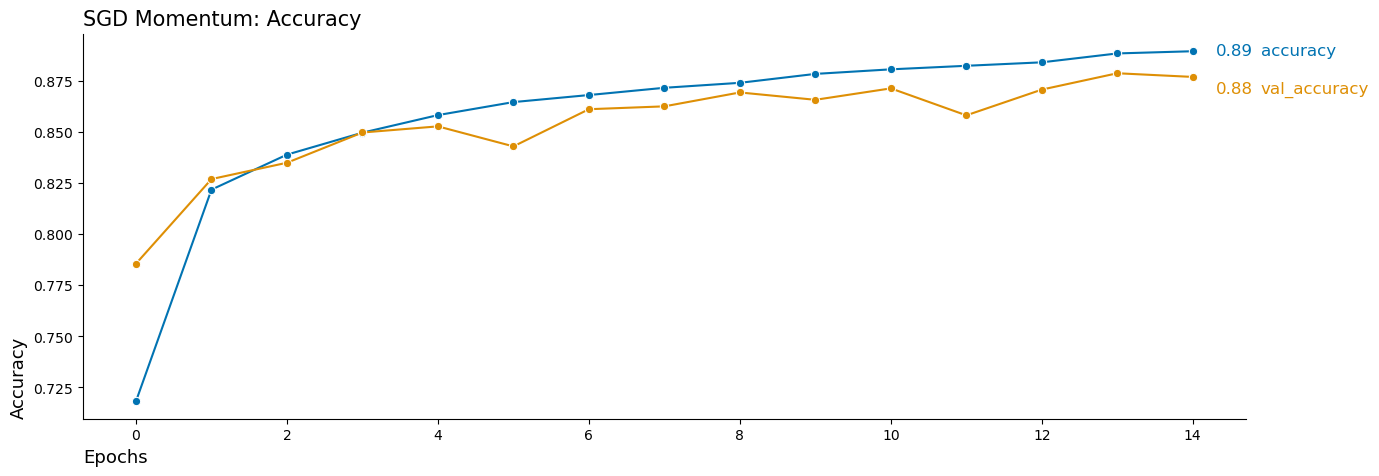

In [123]:
plot_model_accuracy(best_sgd_momentum_model_history, 'SGD Momentum')

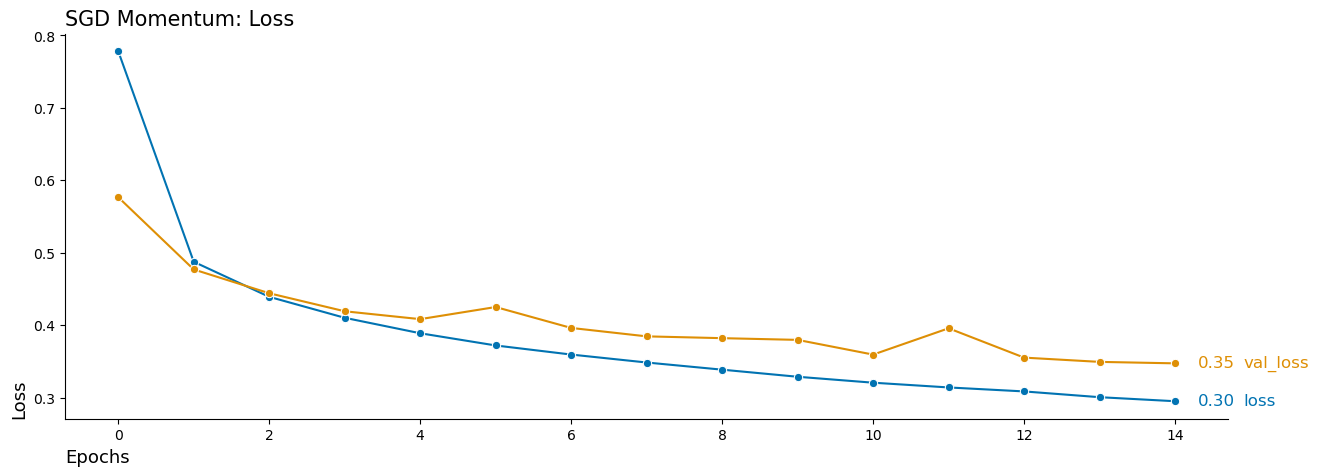

In [125]:
plot_model_loss(best_sgd_momentum_model_history, 'SGD Momentum')

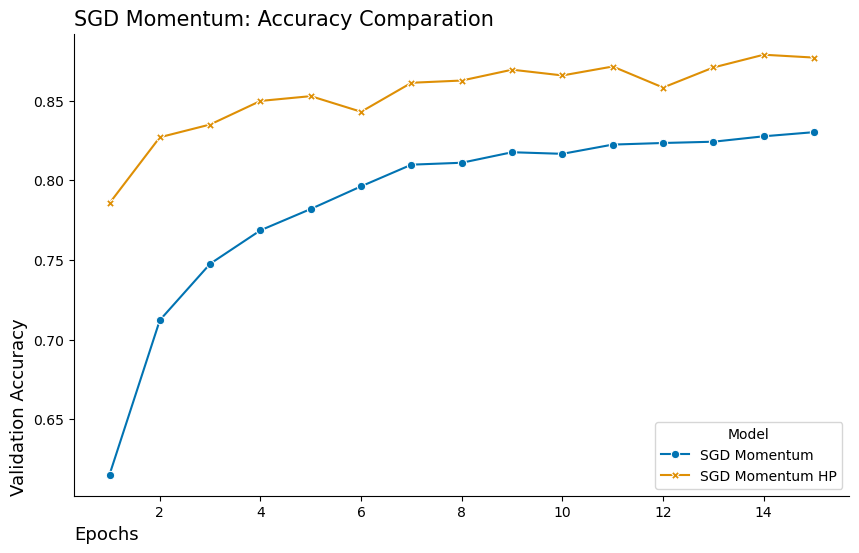

In [127]:
compare_accuracy_curve(sgd_momentum_netwrok_history, best_sgd_momentum_model_history, 'SGD Momentum')

## **Adam**

The Adam optimizer combines the advantages of SGD with Momentum and RMSprop by adapting learning rates for each parameter based on first and second moments of gradients. It is efficient, handles sparse gradients well, and works effectively for many machine learning tasks without extensive hyperparameter tuning.

In [91]:
network = models.Sequential()
network.add(layers.Input(shape=(28*28,)))
network.add(layers.Dense(300, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

network.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', 'Precision'])

adam_netwrok_history = network.fit(X_train_prep, y_train_categorical, batch_size=32, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))
networks["adam"] = adam_netwrok_history

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.8532 - accuracy: 0.7607 - loss: 0.6944 - val_Precision: 0.8650 - val_accuracy: 0.8356 - val_loss: 0.4541
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8890 - accuracy: 0.8620 - loss: 0.3753 - val_Precision: 0.8911 - val_accuracy: 0.8622 - val_loss: 0.3898
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.9011 - accuracy: 0.8775 - loss: 0.3317 - val_Precision: 0.8976 - val_accuracy: 0.8702 - val_loss: 0.3707
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9057 - accuracy: 0.8842 - loss: 0.3103 - val_Precision: 0.8895 - val_accuracy: 0.8674 - val_loss: 0.3685
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9112 - accuracy: 0.8918 - loss: 0.2884 - val_Precision: 0.8946 - val_accuracy: 0.8748 - val_loss: 0.3534
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9151 - accuracy: 0.8984 - loss: 0.2741 - val_Precision: 0.899

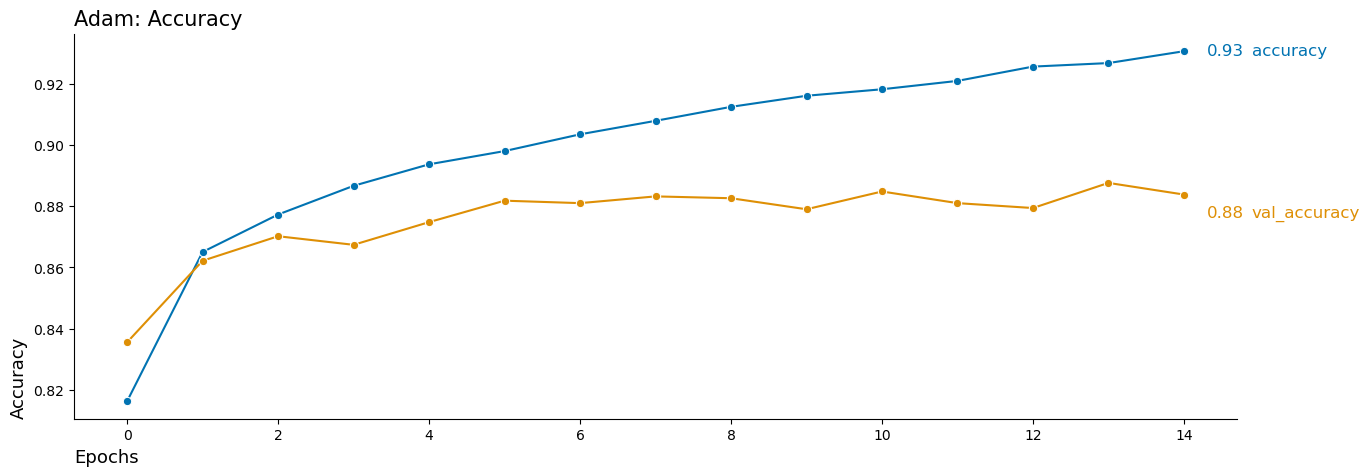

In [92]:
plot_model_accuracy(adam_netwrok_history, 'Adam')

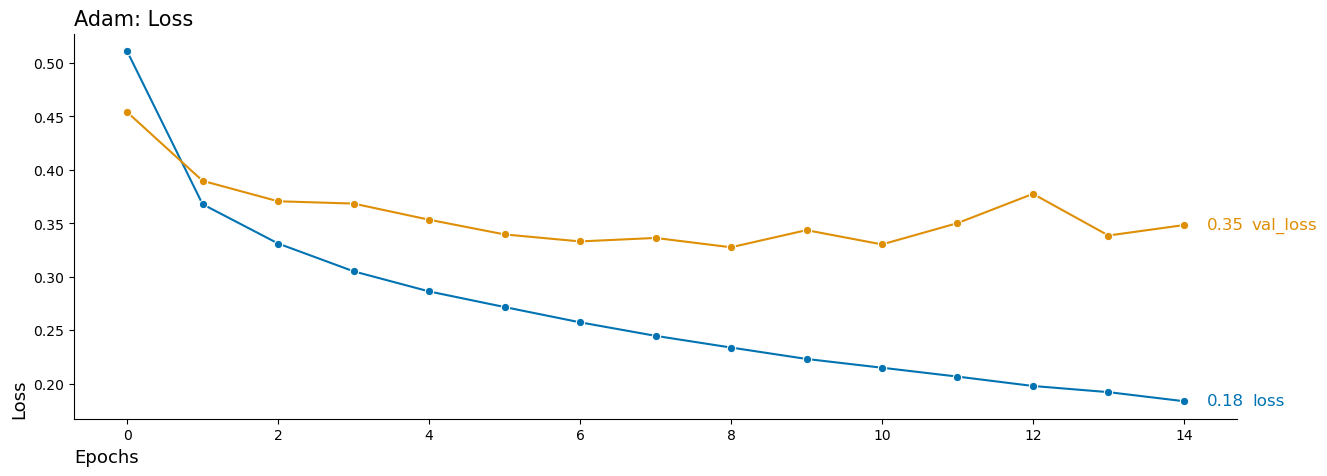

In [93]:
plot_model_loss(adam_netwrok_history, 'Adam')

It has the best metrics, with the lowest val lost and the highest val accuracy, but we can see that it has high overfitting, let's see if we can improve it.

In [162]:
adam_network_hp = build_hp(optimizer_name='ADAM')
adam_network_hp.search(
    X_train_prep, y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_prep, y_val_categorical),
    callbacks=[early_stopping, ClearTrainingOutput()]
)

Reloading Tuner from .\ADAM\tuner0.json


In [164]:
best_adam = adam_network_hp.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp_name in best_adam.values.keys():
    print(f"{hp_name}: {best_adam.get(hp_name)}")

Best Hyperparameters:
learning_rate: 0.01
layers: 1
units_layer_0: 320
dropout_rate_layer_0: 0.4
units_layer_1: 192
dropout_rate_layer_1: 0.30000000000000004
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [166]:
best_adam_model = adam_network_hp.hypermodel.build(best_adam)
best_adam_model_history = best_adam_model.fit(X_train_prep, y_train_categorical, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7555 - loss: 0.6627 - val_accuracy: 0.8366 - val_loss: 0.4515
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8236 - loss: 0.4829 - val_accuracy: 0.8488 - val_loss: 0.4304
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8346 - loss: 0.4523 - val_accuracy: 0.8480 - val_loss: 0.4206
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8454 - loss: 0.4309 - val_accuracy: 0.8578 - val_loss: 0.4058
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8489 - loss: 0.4154 - val_accuracy: 0.8564 - val_loss: 0.4048
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8514 - loss: 0.4043 - val_accuracy: 0.8596 - val_loss: 0.3919
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8555 - loss: 0.3998 - val_accuracy: 0.8530 - val_loss: 0.4202
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8603 - loss: 0.3864 - 

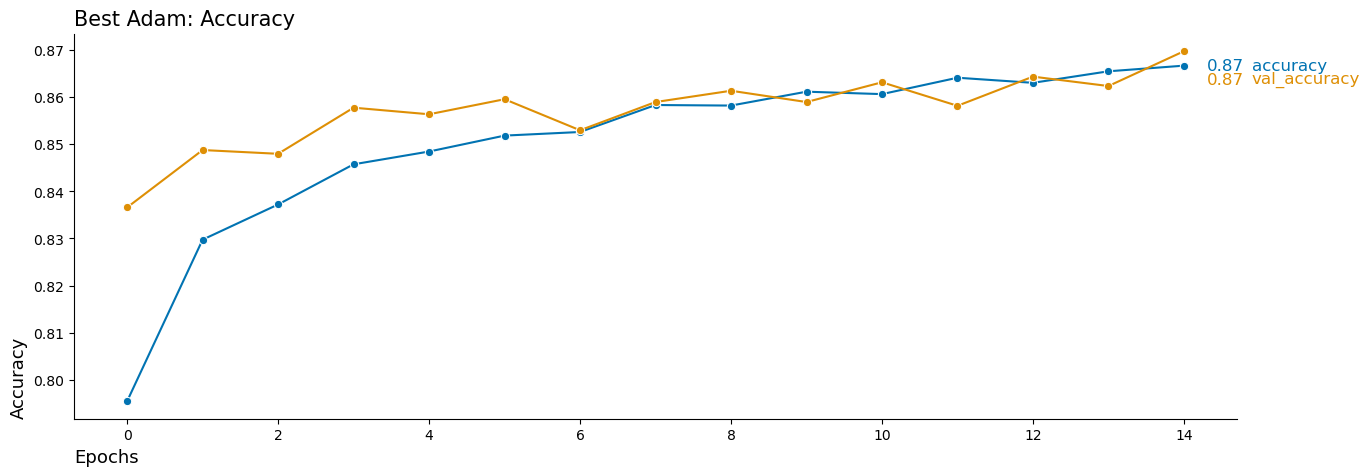

In [167]:
plot_model_accuracy(best_adam_model_history, 'Best Adam')

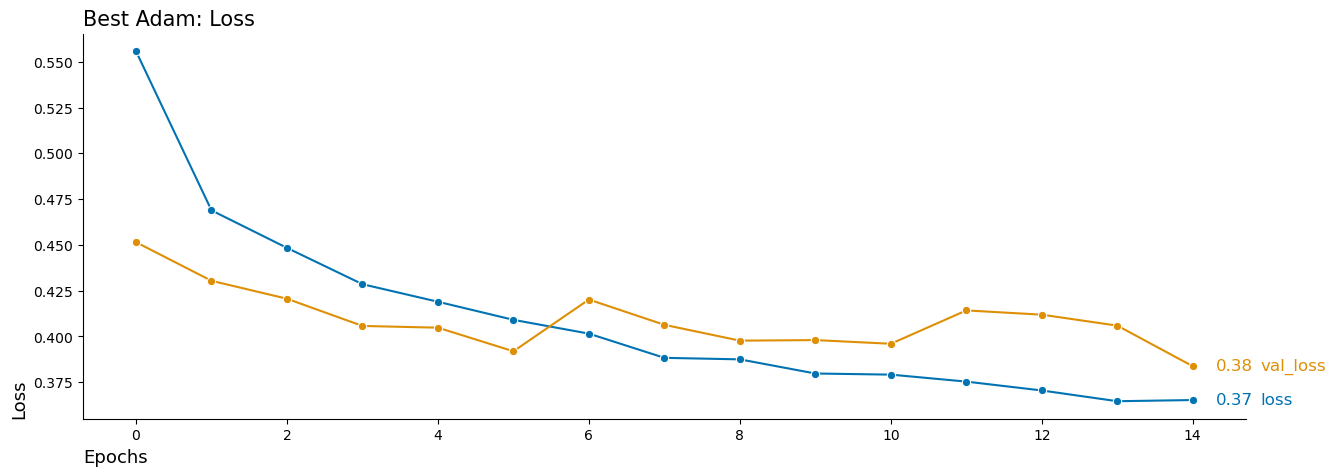

In [170]:
plot_model_loss(best_adam_model_history, 'Best Adam')

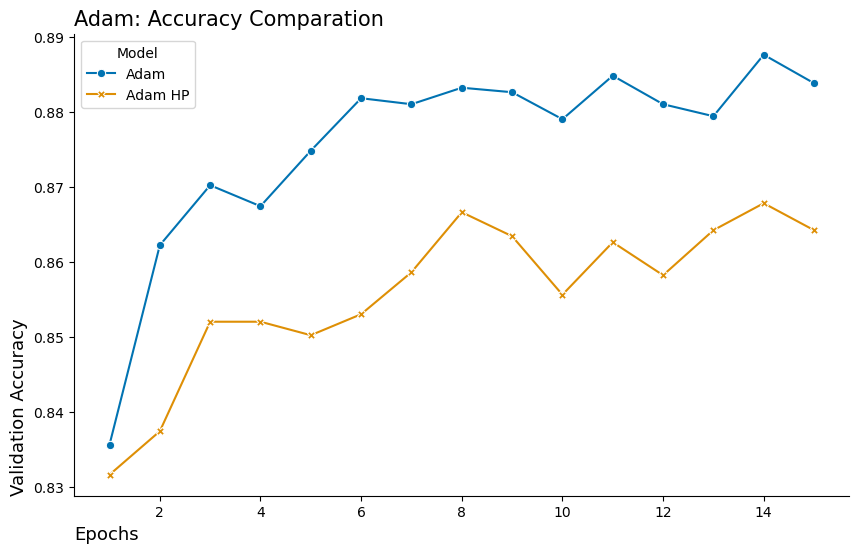

In [137]:
compare_accuracy_curve(adam_netwrok_history, best_adam_model_history, 'Adam')

With the hyperparameters, we could reduce a bit the overfitting, but it is not enough.

## **RMSPro**

The RMSprop optimizer adjusts the learning rate for each parameter by dividing the gradient by a moving average of recent squared gradients. This helps maintain a consistent step size and improves convergence, especially for models with non-stationary objectives or noisy gradients.

In [139]:
network = models.Sequential()
network.add(layers.Input(shape=(28*28,)))
network.add(layers.Dense(300, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

network.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(),
                metrics=['accuracy', 'Precision'])

rmsprop_netwrok_history = network.fit(X_train_prep, y_train_categorical, batch_size=32, epochs=15,
                     validation_data=(X_val_prep, y_val_categorical))
networks["rmsprop"] = rmsprop_netwrok_history

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.8424 - accuracy: 0.7392 - loss: 0.7267 - val_Precision: 0.8524 - val_accuracy: 0.8246 - val_loss: 0.4864
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8831 - accuracy: 0.8540 - loss: 0.3931 - val_Precision: 0.8896 - val_accuracy: 0.8548 - val_loss: 0.4034
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.8978 - accuracy: 0.8735 - loss: 0.3418 - val_Precision: 0.8786 - val_accuracy: 0.8570 - val_loss: 0.3937
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9027 - accuracy: 0.8830 - loss: 0.3170 - val_Precision: 0.8950 - val_accuracy: 0.8740 - val_loss: 0.3638
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.9067 - accuracy: 0.8892 - loss: 0.2998 - val_Precision: 0.8901 - val_accuracy: 0.8692 - val_loss: 0.3644
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Precision: 0.9130 - accuracy: 0.8970 - loss: 0.2770 - val_Precision: 0.896

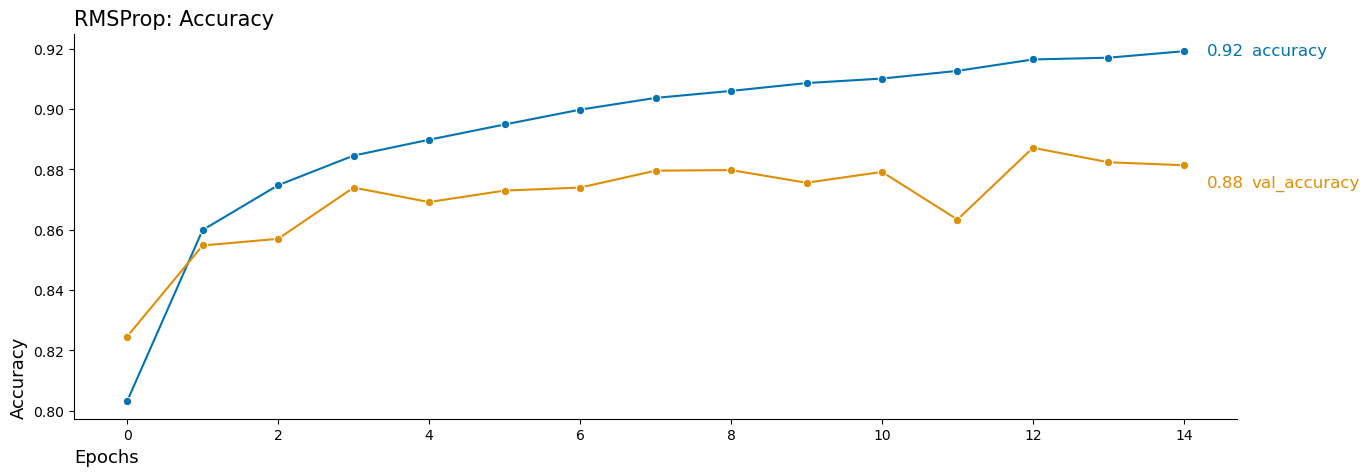

In [141]:
plot_model_accuracy(rmsprop_netwrok_history, 'RMSProp')

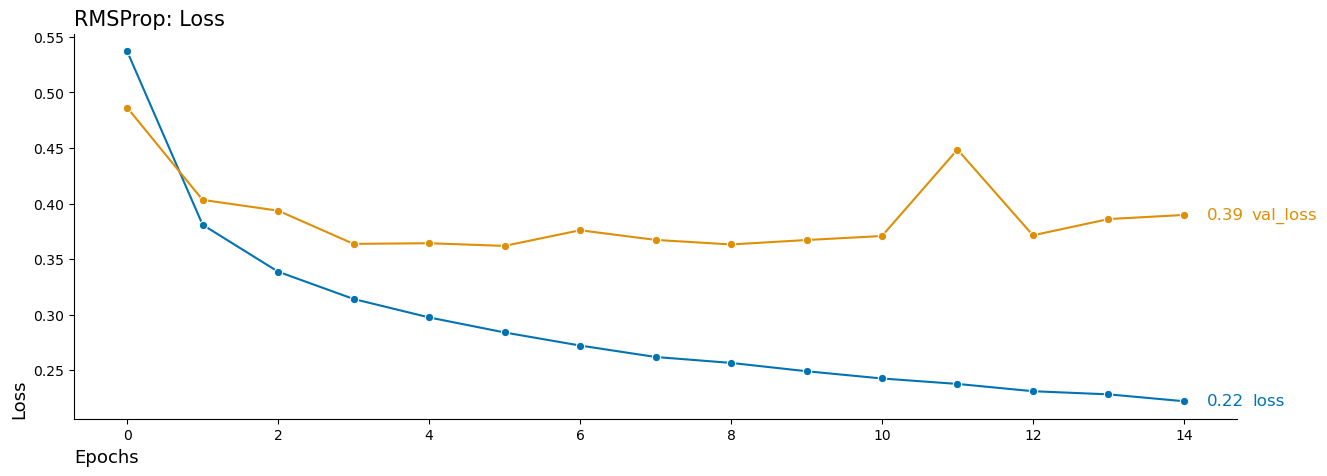

In [143]:
plot_model_loss(rmsprop_netwrok_history, 'RMSProp')

We got similar metrics and high overfitting like Adam optimizer.

In [145]:
rmsprop_network_hp = build_hp(optimizer_name='RMSPROP')

rmsprop_network_hp.search(
    X_train_prep, y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_prep, y_val_categorical),
    callbacks=[early_stopping, ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 21s]
val_accuracy: 0.8640000224113464

Best val_accuracy So Far: 0.8871999979019165
Total elapsed time: 00h 05m 23s


In [146]:
best_rmsprop = rmsprop_network_hp.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp_name in best_rmsprop.values.keys():
    print(f"{hp_name}: {best_rmsprop.get(hp_name)}")

Best Hyperparameters:
learning_rate: 0.001
layers: 1
units_layer_0: 384
dropout_rate_layer_0: 0.2
units_layer_1: 288
dropout_rate_layer_1: 0.1
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


In [147]:
best_rmsprop_model = rmsprop_network_hp.hypermodel.build(best_rmsprop)
best_rmsprop_model_history = best_rmsprop_model.fit(X_train_prep, y_train_categorical, epochs=15, batch_size=1024,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5493 - loss: 1.7792 - val_accuracy: 0.7124 - val_loss: 0.9228
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7256 - loss: 0.8331 - val_accuracy: 0.7600 - val_loss: 0.6953
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7707 - loss: 0.6518 - val_accuracy: 0.7798 - val_loss: 0.6172
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7899 - loss: 0.5883 - val_accuracy: 0.7748 - val_loss: 0.5872
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8025 - loss: 0.5476 - val_accuracy: 0.8054 - val_loss: 0.5421
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8160 - loss: 0.5184 - val_accuracy: 0.8090 - val_loss: 0.5285
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8210 - loss: 0.4934 - val_accuracy: 0.8158 - val_loss: 0.5110
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.4828 - val_accuracy: 0.8216 - val_loss:

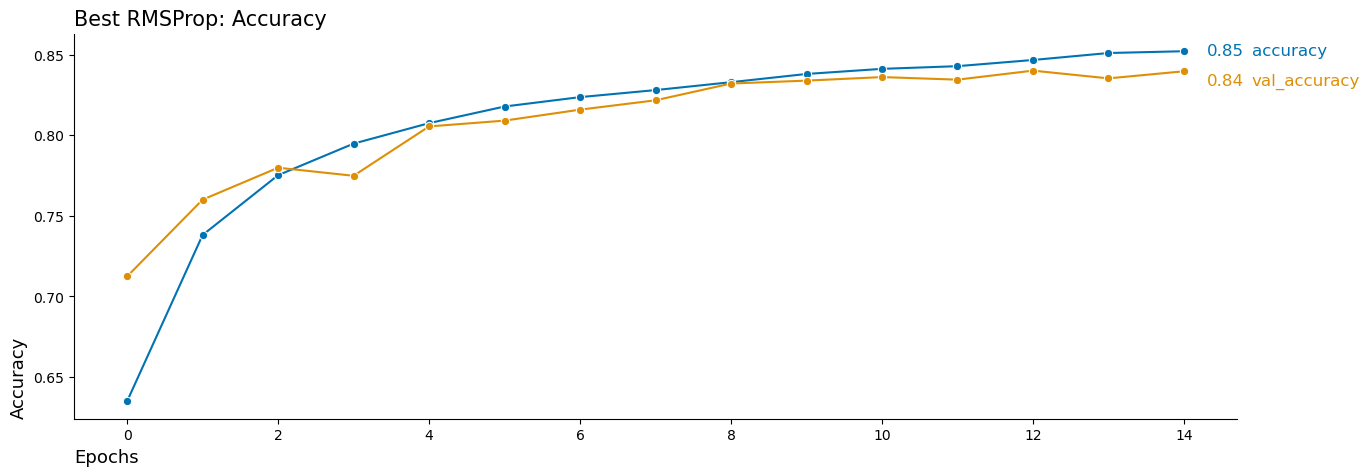

In [148]:
plot_model_accuracy(best_rmsprop_model_history, 'Best RMSProp')

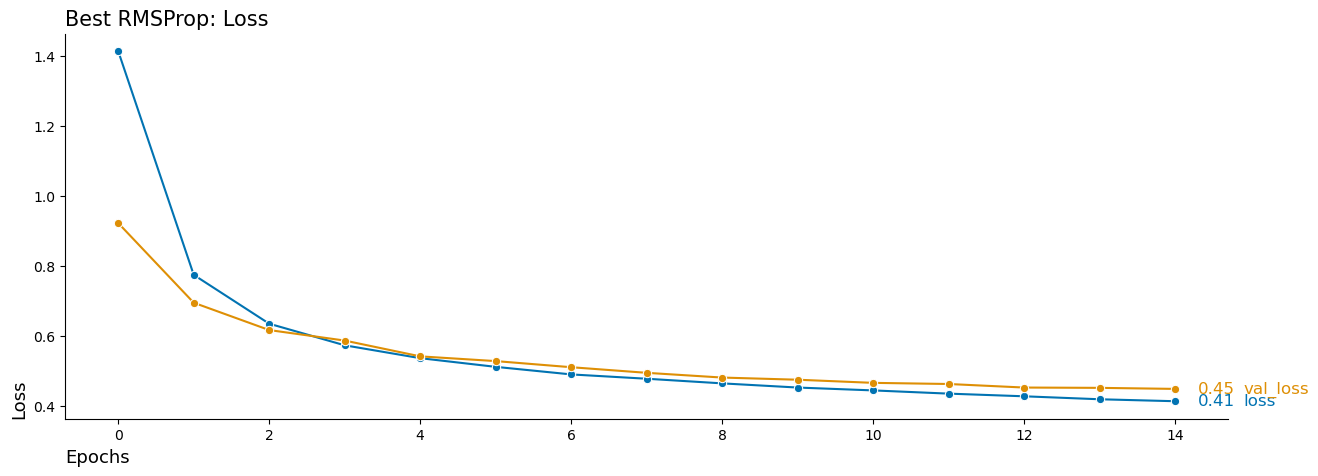

In [149]:
plot_model_loss(best_rmsprop_model_history, 'Best RMSProp')

Certainly, by tuning the hyperparameters we have improved the model, solving a bit the overfitting, better than the base model and Adam model.

Taking all the tested networks, I think the best model is this one, due to its metrics and the lowest overfitting.

## **Model Evaluation**

Now that I have selected a model, let's see how is its behavior with unseen data in order to confirm if the model is optimal.

In [157]:
test_loss, test_acc = best_rmsprop_model.evaluate(X_test_prep, y_test_categorical)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.8440 - loss: 0.4302


In [159]:
print("Test Acc", test_acc)
print("Test Loss", test_loss)

Test Acc 0.8393999934196472
Test Loss 0.440168172121048


With unseen data, the model predicted with good loss and accuracy, similar to the validation metrics.

-----------------------------

## **Appendix: Data Augmentation**

Data Augmentation is a technique used to artificially increase the size and diversity of a training dataset by applying transformations to existing data. It introduces variations such as flipping, rotating, scaling, cropping, or shifting images, creating new examples that retain the original labels. This process helps the model become more robust by exposing it to a wider range of scenarios, reducing overfitting and improving generalization to unseen data.

We have seen that our model with Adam optimizer had overfitting, I will encrease the training set in order to solve that overfitting.

I use ImageDataGenerator, there we can set different properties such as rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip, and fill_mode. But in this case I will use just width_shift_range and height_shift_range.

In [172]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

train_images = transformer.fit_transform(X_train.reshape((60000, 28*28)))

datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05
)

augmentations_per_image = 3  # I create 3 different images for each example of the training set
augmented_images = []
augmented_labels = []

for i in range(train_images.shape[0]):
    image = train_images[i].reshape((1, 28, 28, 1))
    label = y_train[i]

    count = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        count += 1
        if count >= augmentations_per_image:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Original training data size: {train_images.shape[0]}")
print(f"Augmented training data size: {augmented_images.shape[0]}")

Original training data size: 60000
Augmented training data size: 180000


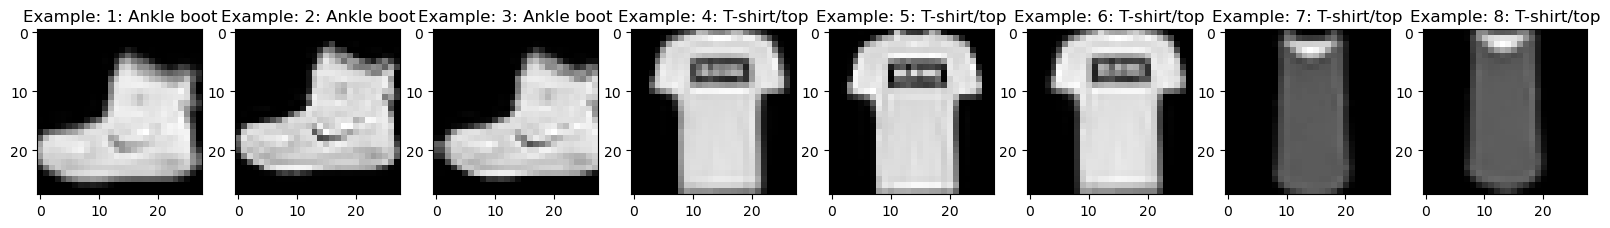

In [174]:
plt.figure(figsize=(20,4))
for index, img, img_class in zip(range(1,9), augmented_images[:8], augmented_labels[:8]):
    plt.subplot(1, 8, index)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Example: " + str(index) + ": " + class_labels[img_class])

Above we can see how the changes were applied to the imagenes.

In [176]:
X_train_augmented = np.concatenate([X_train.reshape(X_train.shape[0], 28, 28, 1), augmented_images])
y_train_augmented = np.concatenate([y_train, augmented_labels])

In [178]:
transformer = Normalizer()
X_train_augmented_flat = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_train_augmented_prep = transformer.fit_transform(X_train_augmented_flat)
y_train_augmented_categorical = to_categorical(y_train_augmented)

Now that I have a new training set, I will create the model, and then search the best hyperparameters

In [180]:
adam_aug_network_hp = build_hp(optimizer_name='ADAM_AUG')

adam_aug_network_hp.search(
    X_train_augmented_prep, y_train_augmented_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_prep, y_val_categorical),
    callbacks=[early_stopping, ClearTrainingOutput()]
)

Trial 30 Complete [00h 01m 56s]
val_accuracy: 0.8274000287055969

Best val_accuracy So Far: 0.8629999756813049
Total elapsed time: 00h 22m 53s


In [182]:
augmented_model = adam_aug_network_hp.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp_name in augmented_model.values.keys():
    print(f"{hp_name}: {augmented_model.get(hp_name)}")

Best Hyperparameters:
layers: 2
units_layer_0: 320
dropout_rate_layer_0: 0.30000000000000004
units_layer_1: 224
dropout_rate_layer_1: 0.2
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022


In [186]:
augmented_adam_model = adam_aug_network_hp.hypermodel.build(augmented_model)
augmented_adam_model_history = augmented_adam_model.fit(X_train_augmented_prep, y_train_augmented_categorical, epochs=15, batch_size=32,
                     validation_data=(X_val_prep, y_val_categorical))

Epoch 1/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.4456 - loss: 1.6913 - val_accuracy: 0.7148 - val_loss: 0.7375
Epoch 2/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7124 - loss: 0.7588 - val_accuracy: 0.7672 - val_loss: 0.6086
Epoch 3/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7524 - loss: 0.6537 - val_accuracy: 0.7950 - val_loss: 0.5586
Epoch 4/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7740 - loss: 0.6040 - val_accuracy: 0.8102 - val_loss: 0.5249
Epoch 5/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7888 - loss: 0.5690 - val_accuracy: 0.8202 - val_loss: 0.5010
Epoch 6/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8000 - loss: 0.5445 - val_accuracy: 0.8262 - val_loss: 0.4795
Epoch 7/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8071 - loss: 0.5257 - val_accuracy: 0.8314 - val_loss: 0.4639
Epoch 8/15
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8143 - loss: 0.5089 - 

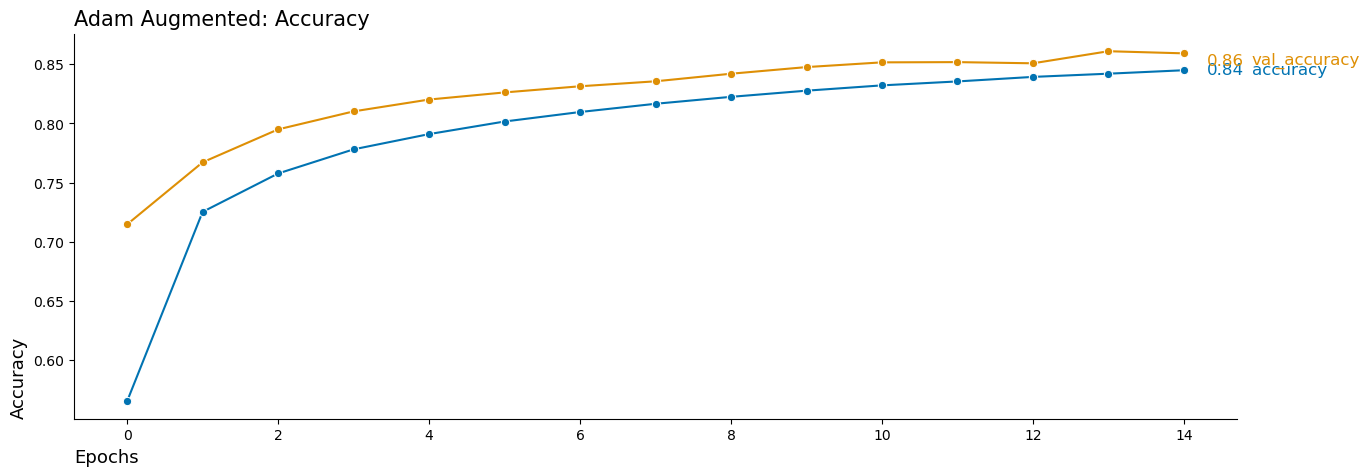

In [187]:
plot_model_accuracy(augmented_adam_model_history,'Adam Augmented')

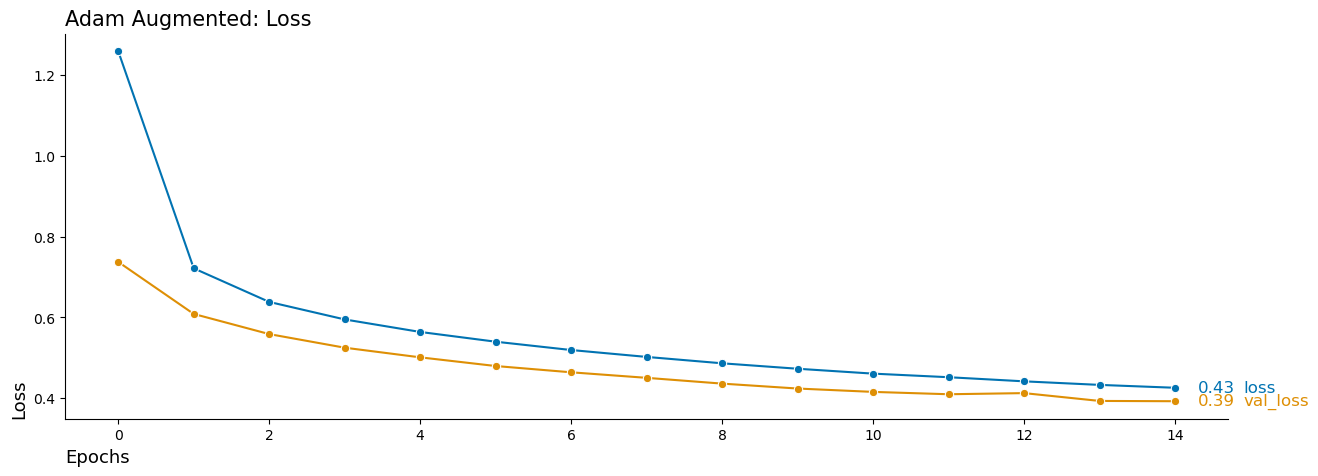

In [188]:
plot_model_loss(augmented_adam_model_history,'Adam Augmented')

Awesome! With data augmentation we have solved completely the overfitting, and the model generalizes very well. No doubts about the power of data augmentation.